In [315]:
%load_ext autoreload
%autoreload 2
import numpy as np 
from logistic_regression import CustomeLogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [316]:
def plot_decision_boundary(clf, X, y, title):
    h = .02 #step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    if isinstance(Z, list):
        Z = np.array(Z)
    Z = Z.reshape(xx.shape)

    #Plot 
    plt.figure()
    plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)

    #Plot the scatter points
    plt.scatter(X[:, 0], X[:, 1], c = y, cmap = cmap_bold, edgecolors='k', s= 20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.show()

In [317]:
class Linear_SVM:
    def __init__(self, C =1, learning_rate = 0.001, epochs = 200, batch_size = 64, lmda = 0.1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.lmda = lmda
        self.C= C
    def fit(self, X, y):
        X = torch.tensor(X, dtype= torch.float32)
        y = torch.tensor(y, dtype = torch.float32)

        num_feature = X.shape[1]
        self.W = torch.randn(num_feature, 1, requires_grad= True, dtype = torch.float32)
        self.b = torch.randn(1, requires_grad= True, dtype = torch.float32)

        optimizer = torch.optim.SGD([self.W, self.b], lr = self.learning_rate)

        for epoch in range(self.epochs):
            dataloader = DataLoader(TensorDataset(X,y), batch_size= self.batch_size, shuffle= True)
            for batch_X, batch_y in dataloader:
                # torch.clamp() choose each element to be larger than 0, otherwise 0 
                hinge_loss = torch.mean(torch.clamp(1- batch_y * (batch_X @ self.W + self.b), min=0))
                reg_loss = 0.5 * self.lmda * torch.sum(self.W ** 2)/self.C #regularization loss
                loss = hinge_loss + reg_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
    def predict(self, X):
        X = torch.tensor(X, dtype = torch.float32)
        return ((torch.sign(X @ self.W  +self.b)+1)/2).detach().numpy()
    
    def score(self, X , y):
        # torch.tensor(y, dtype= torch.float32) makes y into a tensor with size y.shape which is (750, )
        y = torch.tensor(y, dtype= torch.float32).unsqueeze(1)
        y_pred = torch.tensor(self.predict(X), dtype= torch.float32)
        return torch.mean((y_pred == y).float())


In [318]:
class KernelSVM(Linear_SVM):
    def __init__(self, kernel = 'linear', degree = 3, gamma = None, coef0 = 0, **kwargs):
        super().__init__(**kwargs)
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
    
    def compute_kernel(self, X1, X2):
        if self.kernel == 'linear':
            return X1 @ X2.T
        
        elif self.kernel == 'rbf':
            gamma = self.gamma or 1/X1.shape[1]
            pairwise_sq_dists = torch.sum(X1 **2, dim=1, keepdim= True) - 2*X1@X2.T + torch.sum(X2 ** 2, dim = 1)
            return torch.exp(-gamma * pairwise_sq_dists)
        
        elif self.kernel == 'polynomial':
            return (X1@X2.T * self.gamma + self.coef0) ** self.degree

    def fit(self, X, y):
        self.X_train = torch.tensor(X, dtype= torch.float32)
        self.y_train = torch.tensor(y, dtype = torch.float32)
        K = self.compute_kernel(self.X_train, self.X_train)
        super().fit(K, y)
    
    def predict(self, X):
        X = torch.tensor(X, dtype = torch.float32)
        K = self.compute_kernel(X, self.X_train)
        return super().predict(K)

In [319]:
class KernelLogisticRegression:
    '''
    The KernelLogisticRegression class extends your original CustomeLogisticRegression 
    by introducing kernel functions for transforming the input data into a higher-dimensional space.
    '''
    def __init__(self, learning_rate,C= 1, kernel = 'linear', degree = 3, gamma = None, coef0 = 0 ,**kwargs):
        '''
        The class takes additional arguments like kernel, degree, gamma, and coef0, 
        which determine the type of kernel function to be used and its parameters.
        '''
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.learning_rate = learning_rate
        self.C = C
    
    def compute_kernel(self, X1, X2):
        if self.kernel == 'polynomial':
            return (X1@X2.T *self.gamma + self.coef0) ** self.degree
        elif self.kernel == 'rbf':
            gamma = self.gamma or 1/ X1.shape[1]
            pairwise_sq_dists = torch.sum(X1**2, dim = 1, keepdim = True) - 2*X1 @X2.T + torch.sum(X2**2, dim = 1)
            return torch.exp(-gamma*pairwise_sq_dists)
        
        elif self.kernel == 'linear':
            return X1 @ X2.T
        
    def fit(self, X, y):
        self.X_train = torch.tensor(X, dtype = torch.float32)
        self.y_train = torch.tensor(y, dtype = torch.float32)
        K = self.compute_kernel(self.X_train, self.X_train)
        scaler = StandardScaler().fit(K)
        K_scaled = scaler.transform(K)
        self.scaler = scaler

        self.model = LogisticRegression(solver = 'lbfgs')
        self.model.fit(K_scaled, y)

    def predict(self, X):
        X = torch.tensor(X, dtype= torch.float32)
        K = self.compute_kernel(X, self.X_train).numpy()
        K_scaled = self.scaler.transform(K)
        return self.model.predict(K_scaled)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
        

In [320]:
def best_linear(x_train, y_train, x_val, y_val, x_test, y_test):
    best_lr = None
    best_epochs = None
    best_lambda = None
    best_batch = None
    best_model = None
    lrs = np.linspace(0.001, 0.081, 4)
    epochs_list = np.linspace(50, 250, 2)
    lambdas = np.linspace(0.01, 0.21, 4)
    batch_sizes = [32, 64, 128]
    best_score = -1
    Cs = [1,2,3,5,7,10]
    for lr in lrs:
        for epo in epochs_list:
            for ld in lambdas:
                for batch in batch_sizes:
                    for c in Cs:
                        linear_svm_model = Linear_SVM(C = c, learning_rate= lr,epochs= int(epo),batch_size= batch, lmda =  ld)
                        linear_svm_model.fit(x_train, y_train)
                        score = linear_svm_model.score(x_val, y_val).item()
                        if score > best_score:
                            best_score = score
                            best_lr = lr
                            best_epochs = epo
                            best_lambda = ld
                            best_batch = batch
                            best_model = linear_svm_model
                        if best_score == 1:
                            break
    #score on test 
    print(f'highest test score is {best_model.score(x_test, y_test).item()} with {best_lr} lr, {best_lambda} lambda, {best_batch} best size, and {best_epochs} epochs')
    return best_model.score(x_test, y_test).item(), best_model

In [343]:
def best_svm_kernel(x_train, y_train, x_val, y_val, x_test, y_test, kernel, model):
    best_score = -1
    best_model = None

    lr = 0.0001
    epo = 70
    lambdas = np.linspace(0.11, 0.21, 2)
    batch  = 64
    gammas =  [0.001,0.1, 1, 10]
    coefs = [1, 2, 3, 5]
    for ld in lambdas:
        if kernel == 'polynomial':
            for gamma in gammas:
                for coef in coefs:
                    for degree in [2,3,4,6,7]:
                        for c in [5, 10, 40, 70, 90, 100]:
                            if model == 'KernelSVM':
                                kernelsvm_model = KernelSVM(C= c, learning_rate = lr, epochs = epo, batch_size = batch, lmda = ld, gamma= gamma, degree= degree, coef0= coef, kernel= kernel)
                            else:
                                kernelsvm_model = KernelLogisticRegression(C = c, learning_rate = lr, epochs = epo, batch_size = batch, lmda = ld, gamma= gamma, degree= degree, coef0= coef, kernel= kernel)
                            kernelsvm_model.fit(x_train, y_train)
                            score_kern = kernelsvm_model.score(x_val, y_val).item()
                            if score_kern > best_score:
                                best_score = score_kern
                                best_model = kernelsvm_model
        elif kernel =='rbf':
            for gamma in [0.0001, 0.0005, 0.001, 0.005, 0.1, 1, 10]:
                for c in [1, 5, 10, 20, 40, 50, 70, 90, 100]:
                    if model == 'KernelSVM':
                        kernelsvm_model = KernelSVM(C = c, learning_rate = lr, epochs = epo, batch_size = batch, lmda = ld, gamma= gamma, kernel= kernel)
                    else:
                        kernelsvm_model = KernelLogisticRegression(C = c, learning_rate = lr, epochs = epo, batch_size = batch, lmda = ld, gamma= gamma, kernel= kernel)
                    kernelsvm_model.fit(x_train, y_train)
                    score_kern = kernelsvm_model.score(x_val, y_val).item()
                    if score_kern > best_score:
                        best_score = score_kern
                        best_model = kernelsvm_model
        elif kernel == 'linear':
            if model == 'KernelSVM':
                kernelsvm_model = KernelSVM(learning_rate = lr, epochs = epo, batch_size = batch, lmda = ld, kernel= kernel)
            else:
                kernelsvm_model = KernelLogisticRegression(learning_rate = lr, epochs = epo, batch_size = batch, lmda = ld, kernel= kernel)
            kernelsvm_model.fit(x_train, y_train)
            score_kern = kernelsvm_model.score(x_val, y_val).item()
            if score_kern > best_score:
                best_score = score_kern
                best_model = kernelsvm_model
            
        print(f"Best score {best_model.score(x_test, y_test)}")
    return best_model.score(x_test, y_test).item(), best_model

In [322]:
def logi_reg(x_train, y_train, x_val, y_val, x_test, y_test):
    best_epoch_lr = None
    best_lr_lr = None
    best_model = None
    best_accuracy = -1
    epochs = [100, 300, 600, 800]
    learning_rates = np.linspace(0.001, 0.1, 10)
    for epoch in epochs:
        for lr in learning_rates:
            lr_model = CustomeLogisticRegression(learning_rate = lr)
            lr_model.fit(x_train, y_train, epoch = epoch)
            accuracy = lr_model.accuracy(y_val, x_val)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_epoch_lr = epoch
                best_lr_lr = lr
                best_model = lr_model
    print(f'{best_model.accuracy(y_test, x_test)} with learning rate {best_lr_lr} and {best_epoch_lr} epochs')
    return best_model.accuracy(y_test, x_test), best_model

2.2.2 Synthetic Dataset-2 (20 pts)

In [323]:
from sklearn.datasets import make_circles
np.random.seed(42)

In [324]:
#Generate the dataset
X_cir, y_cir = make_circles(n_samples=1500, factor=0.5, noise = 0.05)
X_train_val_cir, X_test_cir, y_train_val_cir, y_test_cir= train_test_split(X_cir,y_cir, test_size =250, random_state= 42)
X_train_cir, X_val_cir, y_train_cir, y_val_cir = train_test_split(X_train_val_cir, y_train_val_cir, test_size= 250, random_state= 42)

No handles with labels found to put in legend.


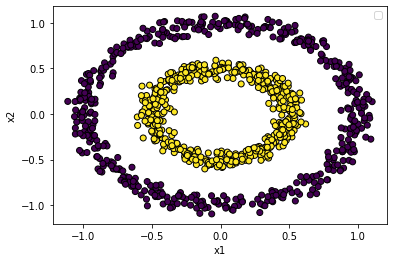

In [308]:
plt.scatter(X_train_cir[:, 0], X_train_cir[:, 1], c = y_train_cir, edgecolors= 'k', cmap='viridis')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

linear svm & logistic regression

0.26 with learning rate 0.07800000000000001 and 100 epochs


<ipython-input-299-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


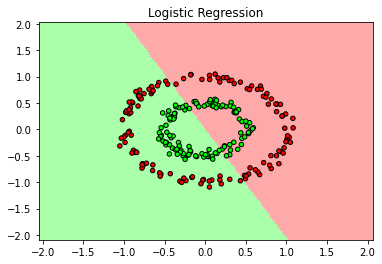

In [309]:
acc_lr, best_lr_cir = logi_reg(X_train_cir, y_train_cir, X_val_cir, y_val_cir, X_test_cir, y_test_cir)
plot_decision_boundary(best_lr_cir,  X_test_cir, y_test_cir, 'Logistic Regression')

In [310]:
acc_linear, best_linear_cir = best_linear(X_train_cir, y_train_cir, X_val_cir, y_val_cir, X_test_cir, y_test_cir)

highest test score is 0.47600001096725464 with 0.001 lr, 0.01 lambda, 32 best size, and 50.0 epochs


<ipython-input-299-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


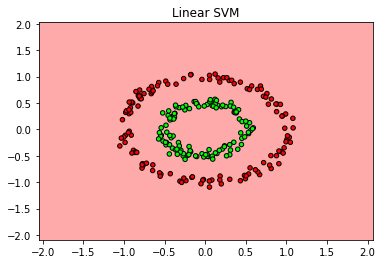

In [311]:
plot_decision_boundary(best_linear_cir, X_test_cir, y_test_cir, 'Linear SVM')

decision boundaries for Kernel SVM (Polynomial & Rbf)

In [325]:
accuracy_rbf_svm, rbf_svm_model = best_svm_kernel(X_train_cir, y_train_cir, X_val_cir, y_val_cir, X_test_cir, y_test_cir, 'rbf', model = 'KernelSVM')
accuracy_rbf_svm

<ipython-input-317-1767651e1aab>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype= torch.float32)
<ipython-input-317-1767651e1aab>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype = torch.float32)


Best score 0.6959999799728394
Best score 0.7319999933242798
Best score 0.8240000009536743
Best score 0.8240000009536743


0.8240000009536743

<ipython-input-317-1767651e1aab>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype = torch.float32)
<ipython-input-316-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


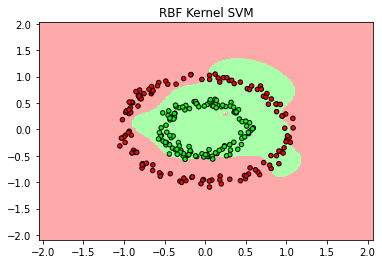

In [327]:
plot_decision_boundary(rbf_svm_model,X_test_cir, y_test_cir, "RBF Kernel SVM")

In [344]:
accuracy_poly_svm, poly_svm = best_svm_kernel(X_train_cir, y_train_cir, X_val_cir, y_val_cir, X_test_cir, y_test_cir, kernel= 'polynomial', model = 'KernelSVM')
accuracy_poly_svm

<ipython-input-317-1767651e1aab>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype= torch.float32)
<ipython-input-317-1767651e1aab>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype = torch.float32)


Best score 0.6039999723434448
Best score 0.7680000066757202


0.7680000066757202

<ipython-input-317-1767651e1aab>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype = torch.float32)
<ipython-input-316-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


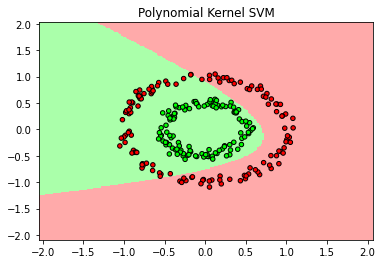

In [345]:
plot_decision_boundary(poly_svm, X_test_cir, y_test_cir, "Polynomial Kernel SVM")

logistic regression with svm kernel

In [330]:
accuracy_rbf_logis_svm, rbf_logis_svm_model = best_svm_kernel(X_train_cir, y_train_cir, X_val_cir, y_val_cir, X_test_cir, y_test_cir, 'rbf', model = 'KernelLogisticRegression')
accuracy_rbf_logis_svm

Best score 1.0
Best score 1.0
Best score 1.0
Best score 1.0


1.0

<ipython-input-316-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


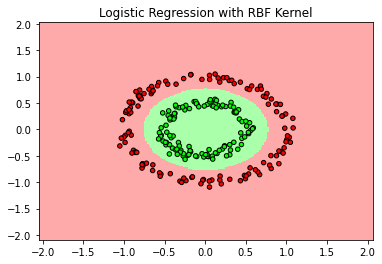

In [331]:
plot_decision_boundary(rbf_logis_svm_model,X_test_cir, y_test_cir, "Logistic Regression with RBF Kernel")

In [332]:
accuracy_poly_logis_svm, poly_logis_svm_model = best_svm_kernel(X_train_cir, y_train_cir, X_val_cir, y_val_cir, X_test_cir, y_test_cir, 'polynomial', model = 'KernelLogisticRegression')
accuracy_poly_logis_svm

Best score 1.0
Best score 1.0
Best score 1.0
Best score 1.0


1.0

<ipython-input-316-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


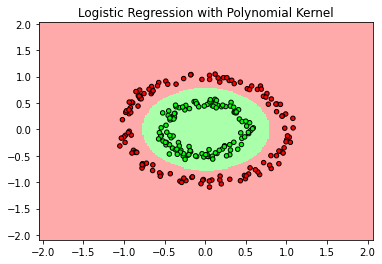

In [333]:
plot_decision_boundary(poly_logis_svm_model, X_test_cir, y_test_cir, "Logistic Regression with Polynomial Kernel")

Train Neural Network from HW4, and K-NN classifiers on this dataset and show decision boundaries.

In [334]:
#Knn Classifiers
def knn(X_combined, y_combined, x_test, y_test, split):
    knn = KNeighborsClassifier()
    knn_grid = {'n_neighbors': np.arange(1, 30)}
    knn_grid_search = GridSearchCV(knn, knn_grid, cv = split)
    knn_grid_search.fit(X_combined, y_combined)

    best_k = knn_grid_search.best_estimator_
    knn_accuracy = best_k.score(x_test, y_test)
    print(knn_accuracy)
    return knn_accuracy, best_k

In [335]:
#knn
X_combined_cir = np.vstack((X_train_cir, X_val_cir))
y_combined_cir = np.hstack((y_train_cir, y_val_cir))
# Create predefinded 
test_fold_cir = np.concatenate([
    np.full(X_train_cir.shape[0], -1),
    np.zeros(X_val_cir.shape[0])
])
predefined_split_cir = PredefinedSplit(test_fold_cir)

knn_cir_accuracy, best_knn_model_cir = knn(X_combined_cir, y_combined_cir, X_test_cir, y_test_cir, predefined_split_cir)
knn_cir_accuracy

c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

1.0


c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

1.0

c:\Users\thong\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
<ipython-input-316-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


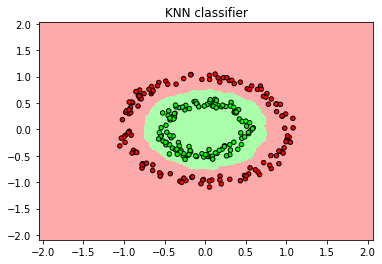

In [336]:
plot_decision_boundary(best_knn_model_cir, X_test_cir, y_test_cir, "KNN classifier")

In [337]:
#neural network
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [338]:
class CircleData(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype= torch.long)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
        

In [339]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
        # Initialize
        nn.init.uniform_(self.fc1.weight,-1, 1)
        nn.init.uniform_(self.fc2.weight,-1, 1)
        nn.init.uniform_(self.fc3.weight,-1,1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = F.softmax(self.fc3(x), dim = 1)
        return x
    
    def predict(self, inputs):
        self.eval()

        with torch.no_grad():
            inputs = torch.tensor(inputs, dtype= torch.float32)
            if len(inputs.shape) == 1:
                inputs = torch.tensor(1, -1)
            outputs = self(inputs)
            _, predicted_indices = torch.max(outputs.data, 1)
        return predicted_indices

In [340]:
###
train_val_data_cir = CircleData(X_train_val_cir, y_train_val_cir)
test_val_cir = CircleData(X_test_cir, y_test_cir)
batch_size = 32
batch_size_test = 10
num_epoch = 50
###
input_size = 2
model = Net(input_size= input_size, hidden_size1= 200, hidden_size2= 100, num_classes= 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.08)
#Create data loaders
train_loader = DataLoader(dataset= train_val_data_cir, batch_size= batch_size, shuffle= True)
test_loader = DataLoader(dataset= test_val_cir, batch_size = batch_size_test, shuffle= False)
#train model 

total_step = len(train_loader)
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(num_epoch):
    train_loss = 0
    train_acc = 0
    model.train()
    correct = 0
    total = 0
    for i, (features, labels) in enumerate(train_loader):
        #flatten
        features = features.reshape(-1, input_size)
        #forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #track loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_acc)

    model.eval()
    test_loss = 0
    test_acc = 0

    with torch.no_grad():
        correct = 0
        total = 0
        for features, labels in test_loader:
            features = features.reshape(-1, input_size)
            outputs = model(features)
            loss = criterion(outputs, labels)

            test_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_loss /= len(test_loader)
        test_accuracy_list.append(accuracy)
        test_loss_list.append(test_loss)
        print(f"Epoch {epoch + 1}/{num_epoch}, Accuracy: {accuracy:.3f}")
            


Epoch 1/50, Accuracy: 0.764
Epoch 2/50, Accuracy: 0.524
Epoch 3/50, Accuracy: 0.524
Epoch 4/50, Accuracy: 0.484
Epoch 5/50, Accuracy: 0.480
Epoch 6/50, Accuracy: 0.508
Epoch 7/50, Accuracy: 0.532
Epoch 8/50, Accuracy: 0.908
Epoch 9/50, Accuracy: 0.952
Epoch 10/50, Accuracy: 1.000
Epoch 11/50, Accuracy: 0.664
Epoch 12/50, Accuracy: 0.536
Epoch 13/50, Accuracy: 1.000
Epoch 14/50, Accuracy: 0.960
Epoch 15/50, Accuracy: 1.000
Epoch 16/50, Accuracy: 0.980
Epoch 17/50, Accuracy: 1.000
Epoch 18/50, Accuracy: 1.000
Epoch 19/50, Accuracy: 1.000
Epoch 20/50, Accuracy: 1.000
Epoch 21/50, Accuracy: 1.000
Epoch 22/50, Accuracy: 1.000
Epoch 23/50, Accuracy: 1.000
Epoch 24/50, Accuracy: 1.000
Epoch 25/50, Accuracy: 1.000
Epoch 26/50, Accuracy: 1.000
Epoch 27/50, Accuracy: 1.000
Epoch 28/50, Accuracy: 1.000
Epoch 29/50, Accuracy: 1.000
Epoch 30/50, Accuracy: 1.000
Epoch 31/50, Accuracy: 1.000
Epoch 32/50, Accuracy: 1.000
Epoch 33/50, Accuracy: 1.000
Epoch 34/50, Accuracy: 1.000
Epoch 35/50, Accuracy: 

<ipython-input-316-eb8d1131e534>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z,  cmap= cmap_light)


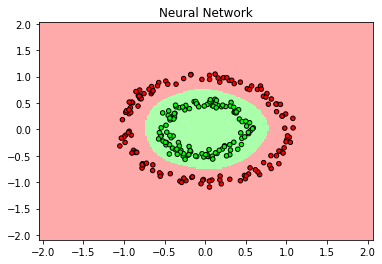

In [341]:
plot_decision_boundary(model, X_test_cir, y_test_cir, "Neural Network")